In [1]:
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272454 sha256=67c0703ed874dec1c3bef9cf42277dca9eea06b4a5be93a8358a4606b1555a33
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
!cp ../input/d/aaditambadkar/torchdetection/* .

In [3]:
# !kaggle competitions download -c vinbigdata-chest-xray-abnormalities-detection

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

import os
import sys

#my imports
from PIL import Image, ImageDraw
import pickle

import matplotlib as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np

import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# import transforms as T
from engine import train_one_epoch, evaluate
import utils
import torchvision
import torchvision.transforms as T2

from math import floor
import datetime

import warnings
warnings.filterwarnings("ignore")

In [5]:
csv = pd.read_csv("../input/vinbigdata-1024-image-dataset/vinbigdata/train.csv")

In [6]:
csv.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


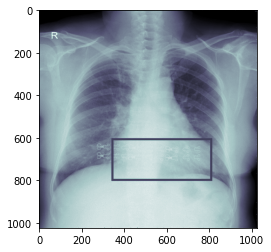

In [7]:
# specify your image path
image_path = '../input/vinbigdata-1024-image-dataset/vinbigdata/train/9a5094b2563a1ef3ff50dc5c7ff71345.png'
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
draw.rectangle([691.0*1024/2080, 1375.0*1024/2336, 1653.0*1024/2080, 1831.0*1024/2336], outline="red", width=10)
plt.pyplot.imshow(img,cmap='bone')
# x = np.asarray(img)
# x/np.max(x)

In [8]:
def custom_normalize(img, mean, std, max_pixel_value=255.0):
    mean = np.array(mean, dtype=np.float32)
    mean *= max_pixel_value

    std = np.array(std, dtype=np.float32)
    std *= max_pixel_value

    denominator = np.reciprocal(std, dtype=np.float32)

    img = img.astype(np.float32)
    img -= mean
    img *= denominator
    return img

In [9]:
class ChestXRayDataset(object):
    def __init__ (self, path, tfms, csv, weights=None):
        #defaults
        self.path=path
        self.tfms=tfms
        self.csv = csv
        self.weights = weights
        #images
        self.imgs = [x+".png" for x in csv['image_id'].tolist()]
    def __getitem__ (self, idx):
        img_path = os.path.join(self.path, 'train', self.imgs[idx])
        img = Image.open(img_path)
        # img = np.asarray(img)
        # img/np.max(img)
        
        boxes = []
        labs = []
        ic = []
        dk = self.csv.loc[self.csv['image_id']==self.imgs[idx][:-4]]
        area = []
        
        for idx, row in dk.iterrows():
            if (int(row['class_id'])!=14): 
                labs.append(int(row['class_id'])+1)
                ic.append(0)
                xmin = float(row['x_min'])
                xmax = float(row['x_max'])
                ymin = float(row['y_min'])
                ymax = float(row['y_max'])

                xmin*=1024
                xmin/=row['width']
                xmax*=1024
                xmax/=row['width']
                ymin*=1024
                ymin/=row['height']
                ymax*=1024
                ymax/=row['height']
                # if (img.shape[0]>img.shape[1]):
                #     rat = 800/img.shape[0]
                #     xmin = rat*xmin
                #     xmax = rat*xmax
                #     ymin = rat*ymin
                #     ymax = rat*ymax
                # else:
                #     rat = 800/img.shape[1]
                #     xmin = rat*xmin
                #     xmax = rat*xmax
                #     ymin = rat*ymin
                #     ymax = rat*ymax
                # xmin = floor(xmin)
                # ymin = floor(ymin)
                # xmax = floor(xmax)
                # ymax = floor(ymax)
                boxes.append([xmin, ymin, xmax, ymax])
                area.append((xmax-xmin)*(ymax-ymin))
                
        if (len(boxes)==0):
            boxes = [[0, 0, 1, 1]]
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            area = torch.ones((1,), dtype=torch.float32)
            iscrowd = torch.as_tensor([0],dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labs, dtype=torch.int64)
            area = torch.as_tensor(area, dtype=torch.float32)
            iscrowd = torch.as_tensor(ic, dtype=torch.int64)
            
        image_id = torch.tensor([idx])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.tfms is not None:
#             img = custom_normalize(img, (0,0,0), (1,1,1))
            # img = Image.fromarray(img)
            img = self.tfms(img)
        return img, target
    def __len__(self):
        return len(self.imgs)

In [10]:
def get_transform():
    transform = []
    transform.append(T2.ToTensor())
#     transform.append(torchvision.transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)))
    return T2.Compose(transform)

In [11]:
# names = csv['image_id'].unique()
# np.random.shuffle(names)
# leg = names.shape[0]
# # names = names[:leg//50]
# # leg = names.shape[0]
# leg

# na_train = names[:-int(math.floor(leg*0.25))]
# na_test = names[-int(math.floor(leg*0.25)):]
# na_train.shape[0]+na_test.shape[0]

# ds_train = csv.loc[csv['image_id'].isin(na_train)]
# ds_test = csv.loc[csv['image_id'].isin(na_test)]

In [12]:
# for i in range(15):
#     print (f"Number of instances for class_id of {i} before balancing: {len(ds_train.loc[ds_train['class_id']==i])}")
#     dsci = ds_train.loc[ds_train['class_id']==i]
#     while len(ds_train.loc[ds_train['class_id']==i]) < 500:
#         ds_train = pd.concat([ds_train, dsci])
#     print (f"Number of instances for class_id of {i} after balancing: {len(ds_train.loc[ds_train['class_id']==i])}")
#     print ()

In [13]:
# ds_train.sample(10)

In [14]:
# test_imgs = ds_test.image_id.unique()
# test_imgs

In [15]:
def intersect(boxa, boxb):
    minx = max(boxa[0], boxb[0])
    miny = max(boxa[1], boxb[1])
    maxx = min(boxa[2], boxb[2])
    maxy = min(boxa[3], boxb[3])
    return [minx, miny, maxx, maxy]
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])
def iou(box_a, box_b):
    box_i = intersect(box_a, box_b)
    box_i_area = box_area(box_i)
    box_a_area = box_area(box_a)
    box_b_area = box_area(box_b)
    u_area = box_a_area+box_b_area-box_i_area
    return (box_i_area/u_area, box_i_area, u_area)

In [16]:
# for i in test_imgs:
#     df = ds_test.loc[ds_test['image_id']==i]
#     i = 0
#     while (i<len(df)):
#         j = i+1
#         while (j<len(df)):
#             if iou([df.iloc[i]['x_min'], df.iloc[i]['y_min'], df.iloc[i]['x_max'], df.iloc[i]['y_max']], 
#                     [df.iloc[j]['x_min'], df.iloc[j]['y_min'], df.iloc[j]['x_max'], df.iloc[j]['y_max']])[0]>=0.4:
#                 if (df.iloc[i]['class_id']==df.iloc[j]['class_id']): 
# #                     print(df.index[i])
# #                     print(df.index[j])
#                     try:
#                         ds_test.drop(df.index[j], inplace=True)
#                     except:
#                         pass
#             j+=1
#         i+=1
# # df.iloc[0]

In [17]:
file_train = open(f"../input/private-model-save-dataset/train-set-v3 (1).pkl", "rb")
file_test = open(f"../input/private-model-save-dataset/test-set-v3 (1).pkl", "rb")
ds_train = pickle.load(file_train)
ds_test = pickle.load(file_test)

In [18]:
ds_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555


In [19]:
def train(model, optimizer, data_loader, device, epoch, print_freq=100):
    model.train()
    itr = 0
    for img, target in data_loader:
        img = list(image.to(device) for image in img)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]
        loss_dict = model(img, target)
        losses = sum (loss for loss in loss_dict.values())
        loss_value = losses.item()
        if (itr%print_freq==0):
            print (f"Epoch [{epoch}], itr [{itr}]", end="\t")
            print (f"Loss: {loss_value}", end="\t")
            print (f"Loss Dictionary: {loss_dict}", end="\t")
            print (datetime.datetime.now())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)
        itr+=1
    

In [20]:
def main () :
    # load a model pre-trained pre-trained on COCO
    model = torch.load("../input/private-model-save-dataset/model-save-6.pkl")
    
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
#     num_classes = 15  
    # get number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    dataset = ChestXRayDataset('../input/vinbigdata-1024-image-dataset/vinbigdata', get_transform(), ds_train)
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=4, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)
    
    model.to(device)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    num_epochs = 3
    for epoch in range(num_epochs):
        # train for one epoch, printing every 1000 iterations
        train(model, optimizer, data_loader, device, epoch, print_freq=500)
        # update the learning rate
        lr_scheduler.step()
        torch.save(model, f"./model-save-{epoch+1}.pkl")
        
#         evaluate(model, data_loader_test, device=device)
    

In [21]:
main()

Epoch [0], itr [0]	Loss: 0.32044708728790283	Loss Dictionary: {'loss_classifier': tensor(0.0987, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1972, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0091, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0154, device='cuda:0', grad_fn=<DivBackward0>)}	2021-08-12 22:46:17.203181
Epoch [0], itr [500]	Loss: 0.1872817724943161	Loss Dictionary: {'loss_classifier': tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0923, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)}	2021-08-12 22:51:38.776861
Epoch [0], itr [1000]	Loss: 0.2741669714450836	Loss Dictionary: {'loss_classifier': tensor(0.0794, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': t

In [22]:
%tb

No traceback available to show.
